In [1]:
import sys
sys.path.append("..")
from project.dataset.lit_module import SeqAnnotationDM

In [ ]:
ds = SeqAnnotationDM(
    "../data/games_0001/train_100K.parquet",
    "../data/games_0001/val_100K.parquet",
    "../data/games_0001/test_100K.parquet",
    32,
    ["Moves"],
    ["pieces"],
    8,
)
ds.setup()

train_loader = ds.train_dataloader()
val_loader = ds.val_dataloader()
test_loader = ds.test_dataloader()

Loading parquet file @  ../data/games_0001/train_100K.parquet  with columns  ['Moves', 'result']
columns:  ['Moves', 'result']  not found


AttributeError: 'ChessDataset' object has no attribute 'df'

In [3]:
import numpy as np
from torch.utils.data import DataLoader
from project.utils.collate import collate_fn_next_token

def find_percentage_zeros(loader):
    total_zeros = 0 
    total_tokens = 0
    zero_percentage_means = []  
    for batch in loader:
        # find percentage of 0 tokens in the batch
        total_tokens += batch[0].numel()
        total_zeros += (batch[0] == 0).sum().item()

        zero_percentage_means.append(
            (batch[0] == 0).sum().item() / batch[0].numel()
        )
    zero_percentage_variace = np.var(zero_percentage_means)  

    
    return total_zeros / total_tokens, zero_percentage_variace


# adapted batch size in train_loader
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
percentage_zeros = np.zeros((len(batch_sizes), 2))
for idx, bs in enumerate(batch_sizes):
    val_set = ds.validate_set
    val_loader = DataLoader(
            val_set,
            bs,
            shuffle=False,
            num_workers=8,
            collate_fn=collate_fn_next_token,
        )
    percentage_zeros[idx] = np.array(find_percentage_zeros(val_loader))
    print(f"Batch size: {bs}")
    print("Val loader percentage of zeros:", percentage_zeros[idx])

Batch size: 1
Val loader percentage of zeros: [0. 0.]
Batch size: 2
Val loader percentage of zeros: [0.18754797 0.01024621]
Batch size: 4
Val loader percentage of zeros: [0.32125764 0.01161236]
Batch size: 8
Val loader percentage of zeros: [0.41959377 0.0095262 ]
Batch size: 16
Val loader percentage of zeros: [0.49089933 0.00657593]
Batch size: 32
Val loader percentage of zeros: [0.54386058 0.00496695]
Batch size: 64
Val loader percentage of zeros: [0.58831763 0.00373449]
Batch size: 128
Val loader percentage of zeros: [0.6231341  0.00261202]
Batch size: 256
Val loader percentage of zeros: [0.65449857 0.00186222]
Batch size: 512
Val loader percentage of zeros: [0.67898972 0.00141119]
Batch size: 1024
Val loader percentage of zeros: [0.69475601 0.00080956]
Batch size: 2048
Val loader percentage of zeros: [0.71263047 0.00093544]
Batch size: 4096
Val loader percentage of zeros: [7.34247682e-01 6.76391722e-04]


Text(0.5, 1.0, 'Percentage of zeros in features vs Batch size')

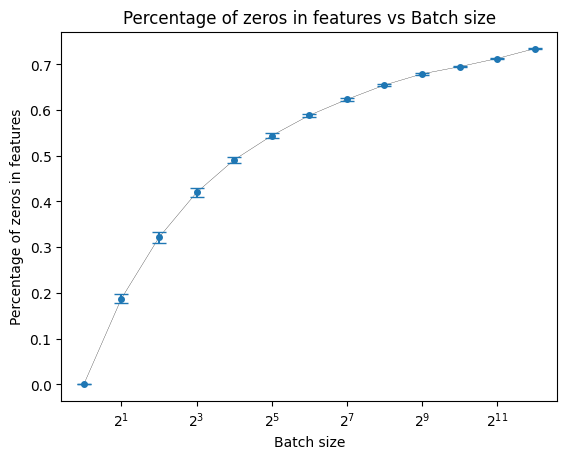

In [5]:
import matplotlib.pyplot as plt
plt.plot(batch_sizes, percentage_zeros[:, 0], color="k", linewidth=.2)
plt.errorbar(
    batch_sizes,
    percentage_zeros[:, 0],
    yerr=percentage_zeros[:, 1],
    fmt='o',
    capsize=5,
    label='Percentage of zeros with variance',
    markersize=4,
)
plt.xscale('log', base=2)
plt.xlabel('Batch size')
plt.ylabel('Percentage of zeros in features')
plt.title('Percentage of zeros in features vs Batch size')